**Hierarchical Clustering & Recommendations (Description Similarity)**

*Preparatory Work & Data Cleaning:*

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp 
import seaborn as sns
%matplotlib inline
import nltk
import nltk.corpus
import re
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
stemmer = SnowballStemmer("english")

In [2]:
movies = pd.read_csv('/Users/Troy/Desktop/STA160-Original_movie/AllMoviesDetailsCleaned.csv', sep=';', low_memory=False)

#make genre columns
genres = set()
movies['genres'] = movies['genres'].astype(str)
for row in movies['genres']:
    row = row.split('|')
    for genre in row:
        genres.add(genre)
        
for g in genres:
    movies["is_genre_" + g.replace(" ","_")] = list(map(lambda x : int(g in str(x)), movies["genres"]))

In [3]:
movie = movies.dropna(axis=0, subset=['overview']) #drop NA's in the data set
movie2 = movie[~movie['genres'].isin(['nan'])] #drop nan values [dropna does not work with nan string]
movie_final = movie2[movie2.overview != 'no overview']  #take out observatiosn with no overview
movie_final

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,is_genre_Music,is_genre_Action,is_genre_Fantasy,is_genre_Documentary,is_genre_Horror,is_genre_Mystery,is_genre_TV_Movie,is_genre_War,is_genre_Thriller,is_genre_Comedy
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,0,0,0,0,0,0,0,0,0,0
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,0,0,0,0,0,0,0,0,0,1
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,...,0,0,0,0,0,0,0,0,0,1
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,...,0,1,0,0,0,0,0,0,1,0
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,...,0,0,0,1,0,0,0,0,0,0
6,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,10.492614,Lucasfilm,United States of America,...,0,1,0,0,0,0,0,0,0,0
7,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",9.915573,Pixar Animation Studios,United States of America,...,0,0,0,0,0,0,0,0,0,0
8,13,55000000,Comedy|Drama|Romance,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,10.351236,Paramount Pictures,United States of America,...,0,0,0,0,0,0,0,0,0,1
9,14,15000000,Drama,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",8.191009,DreamWorks SKG,United States of America,...,0,0,0,0,0,0,0,0,0,0
10,15,839727,Mystery|Drama,tt0033467,en,Citizen Kane,"Newspaper magnate, Charles Foster Kane is take...",3.82689,RKO Radio Pictures,United States of America,...,0,0,0,0,0,1,0,0,0,0


In [4]:
movies

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,is_genre_Music,is_genre_Action,is_genre_Fantasy,is_genre_Documentary,is_genre_Horror,is_genre_Mystery,is_genre_TV_Movie,is_genre_War,is_genre_Thriller,is_genre_Comedy
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,0,0,0,0,0,0,0,0,0,0
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,0,0,0,0,0,0,0,0,0,1
2,5,4000000,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,...,0,0,0,0,0,0,0,0,0,1
3,6,0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,...,0,1,0,0,0,0,0,0,1,0
4,8,42000,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,...,0,0,0,1,0,0,0,0,0,0
5,9,0,Drama,tt0425473,de,Sonntag im August,NaN,0.001647,none,Germany,...,0,0,0,0,0,0,0,0,0,0
6,11,11000000,Adventure|Action|Science Fiction,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,10.492614,Lucasfilm,United States of America,...,0,1,0,0,0,0,0,0,0,0
7,12,94000000,Animation|Family,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",9.915573,Pixar Animation Studios,United States of America,...,0,0,0,0,0,0,0,0,0,0
8,13,55000000,Comedy|Drama|Romance,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,10.351236,Paramount Pictures,United States of America,...,0,0,0,0,0,0,0,0,0,1
9,14,15000000,Drama,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",8.191009,DreamWorks SKG,United States of America,...,0,0,0,0,0,0,0,0,0,0


*Hierarchical Clustering Dendrogram: (Exploratory Data Analysis)*

In [4]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
sample = movie_final.sample(n = 100) #taking a sample since tfidf size of full frame is 9 million elements
sample = sample.reset_index()

In [6]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
movie_list = sample["overview"].tolist()
vec = TfidfVectorizer(tokenizer = tokenize_and_stem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(movie_list) #creating tfidf of the sample

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf)

In [8]:
list_names = sample['genres'].tolist()

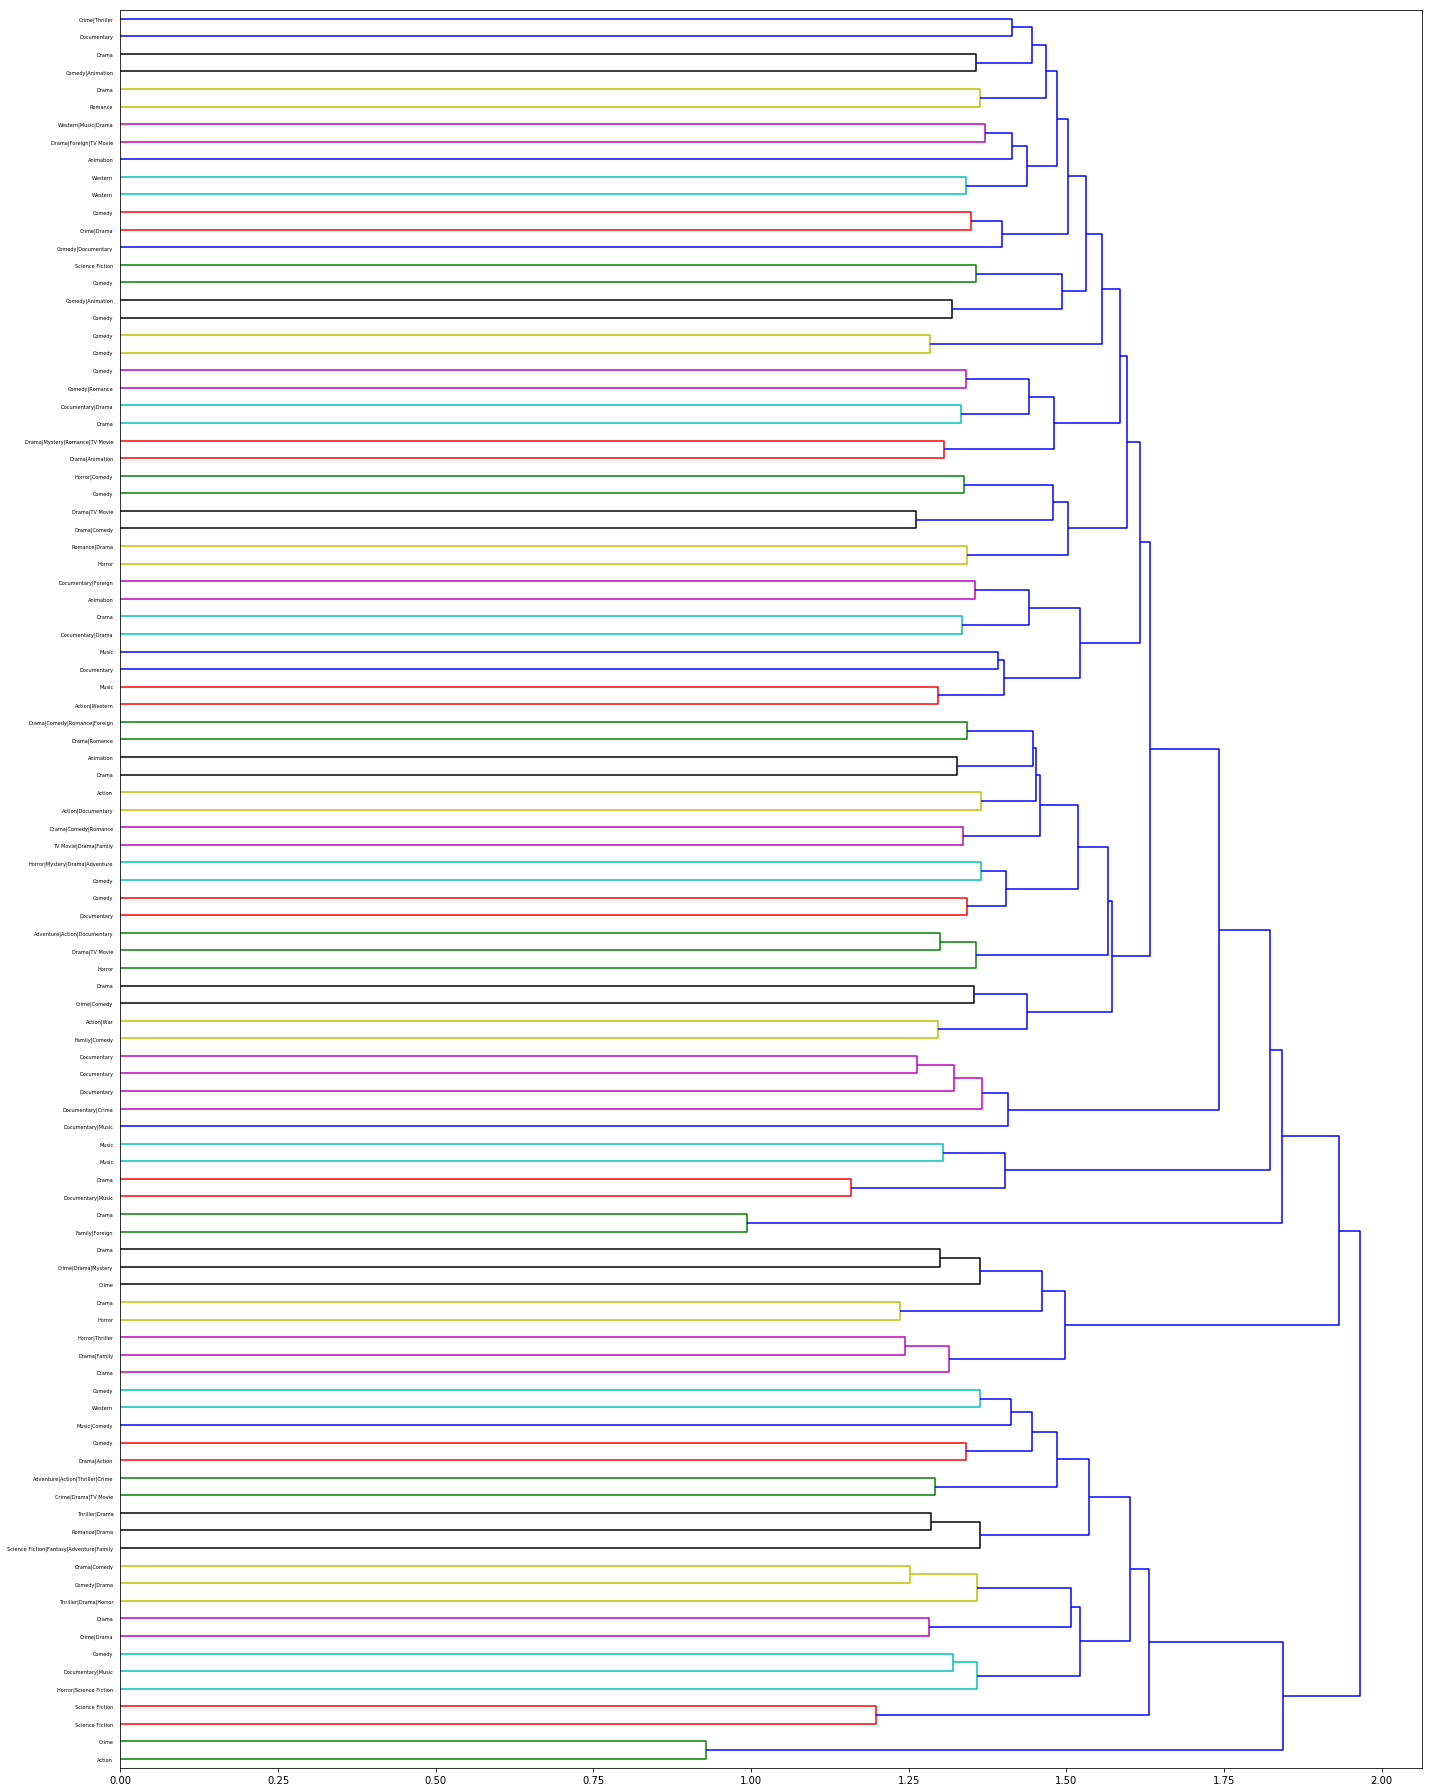

In [9]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 25)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = list_names);

plt.tight_layout() #show plot with tight layout

##dendrogram based on tfidf and cosine similarity. labels are by genre names to explore whether genres cluster together

*Recommendations Based On Cosine Similarity of Movie Descriptions:*

In [65]:
def Recommendation(movie_title):
    """Takes in string of movie's name and returns 5 similar movies as a recommendation"""
    movie_row = movie_final.loc[movie_final["original_title"] == movie_title]
    movie_row = movie_row.reset_index()
    movie_subset = movie_final.loc[movie_final['genres'] == movie_row['genres'][0]]
    movie_subset = movie_subset.reset_index()
    
    if len(movie_subset) < 6:
        print("Not enough movies of the same genre.")
    if len(movie_subset) > 10000:
        movie_row = movie_final.loc[movie_final["original_title"] == movie_title]
        movie_row = movie_row.reset_index()
        movie_subset = movie_final.loc[movie_final['genres'] == movie_row['genres'][0]]
        movie_sample = movie_subset.sample(n = 9999, replace = False) 
        movie_subset = movie_row.append(movie_sample)
        movie_subset = movie_subset.reset_index()  
        
    movie_position = movie_subset.loc[movie_subset["original_title"] == movie_title].index.tolist()

    count_vectorizer = CountVectorizer(stop_words='english') #stop words
    count_vectorizer = CountVectorizer()
    document_matrix = count_vectorizer.fit_transform(movie_subset['overview']) #creating document matrix

    similarity = cosine_similarity(document_matrix) #cosine similarity of document matrix

    sim_df = pd.DataFrame(similarity)
    max_6 = sim_df.nlargest(6, movie_position) #problem with [0] how will you find the placing ... 
    positions = max_6.index.tolist()
    final_df = movie_subset.loc[positions]
    recommend_movie_names = final_df["original_title"].tolist()
    recommend_movie_names.remove(movie_title) #removing inputted movie from this list 

    print("Since you've watched ", movie_title, ", we recommend you watch ", recommend_movie_names[0],", ",
            recommend_movie_names[1], ", ", recommend_movie_names[2], ", ",  recommend_movie_names[3], ", or ",
            recommend_movie_names[4], ".", sep = '')

In [66]:
Recommendation("Star Wars")

Since you've watched Star Wars, we recommend you watch The Empire Strikes Back, 中國超人, Iron Man 2, ガメラ対宇宙怪獣バイラス, or Return of the Jedi.


In [67]:
Recommendation("Forrest Gump")

Since you've watched Forrest Gump, we recommend you watch Dr. T and the Women, Quarter Life Crisis, Commandments, Finding Me, or Очи черные.


In [68]:
Recommendation("American Beauty")

Since you've watched American Beauty, we recommend you watch Uncut Family, Riz, Riders, 積木の箱, or Blue Ridge Fall.


**References**

° http://brandonrose.org/clustering

° https://www.machinelearningplus.com/nlp/cosine-similarity/